In [1]:
import os

import numpy as np

os.chdir(os.path.expanduser("~/l3_project"))
# for when on NCC to be able to import local packages

# imports

In [2]:
import platform

import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
import torch
import torch.nn as nn
import torchvision
from tqdm.autonotebook import tqdm

import dataset_processing.core

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

/tmp/ipykernel_3009056/1835707389.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [3]:
import plotly.express as px
import plotly.graph_objects as go
from umap import UMAP

In [4]:
normalise_transform = dataset_processing.core.tensor_dict_transform_wrapper(transforms.Compose([
    # transforms.ToImage(),
    # transforms.ToDtype(torch.float32, scale=True),
    dataset_processing.core.RSScalingTransform()
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # transforms.Lambda(lambda t: t.clamp(0, 1))
]))

eurosat_train_ds = dataset_processing.eurosat.get_dataset("train", download=False, transforms=normalise_transform)
eurosat_val_ds = dataset_processing.eurosat.get_dataset("val", download=False, transforms=normalise_transform)

In [5]:
eurosat_train_ds[0]

{'image': tensor([[[0.5333, 0.5333, 0.5297,  ..., 0.3620, 0.3723, 0.3667],
          [0.5333, 0.5333, 0.5297,  ..., 0.3620, 0.3723, 0.3667],
          [0.5167, 0.5167, 0.5153,  ..., 0.3667, 0.3673, 0.3677],
          ...,
          [0.5077, 0.5077, 0.5030,  ..., 0.3673, 0.3620, 0.3623],
          [0.4733, 0.4733, 0.4607,  ..., 0.3743, 0.3763, 0.3843],
          [0.4380, 0.4380, 0.4287,  ..., 0.3753, 0.3800, 0.3903]],
 
         [[0.4303, 0.4303, 0.4270,  ..., 0.3260, 0.3273, 0.3293],
          [0.4303, 0.4303, 0.4270,  ..., 0.3260, 0.3273, 0.3293],
          [0.4190, 0.4190, 0.4207,  ..., 0.3300, 0.3270, 0.3260],
          ...,
          [0.4147, 0.4147, 0.4083,  ..., 0.3257, 0.3240, 0.3263],
          [0.3990, 0.3990, 0.3947,  ..., 0.3337, 0.3363, 0.3410],
          [0.3807, 0.3807, 0.3720,  ..., 0.3383, 0.3380, 0.3443]],
 
         [[0.4303, 0.4303, 0.4267,  ..., 0.3610, 0.3660, 0.3623],
          [0.4303, 0.4303, 0.4267,  ..., 0.3610, 0.3660, 0.3623],
          [0.4230, 0.4230, 0.42

In [6]:
def get_n_samples(train_ds, val_ds, n=1000):
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, num_workers=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=32, num_workers=4, shuffle=True)

    train_tensor = torch.zeros(0)
    for i, x in enumerate(train_dataloader):
        if train_tensor.size(0) >= n:
            break
        train_tensor = torch.cat((train_tensor, x['image']), 0) if train_tensor.size else x['image']

    val_tensor = torch.zeros(0)
    val_labels_tensor = torch.zeros(0)
    for i, x in enumerate(val_dataloader):
        if val_tensor.size(0) >= n:
            break
        val_tensor = torch.cat((val_tensor, x['image']), 0) if val_tensor.size else x['image']
        val_labels_tensor = torch.cat((val_labels_tensor, x['label']), 0) if val_labels_tensor.size else x['label']

    text_val_labels = [train_ds.classes[int(i)] for i in val_labels_tensor]
    return train_tensor, val_tensor, val_labels_tensor, text_val_labels

In [7]:
train_data, val_data, val_labels, text_labels = get_n_samples(eurosat_train_ds, eurosat_val_ds, n=1000)
train_data.size(), val_labels.size()

(torch.Size([1024, 3, 64, 64]), torch.Size([1024]))

# Dimensionality Reduction

## Naive UMAP
Just flattening all 3 channels and dimensions

In [8]:
umap_2d = UMAP()
_ = umap_2d.fit(train_data.flatten(1, -1).numpy())

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [9]:
projections: np.ndarray = umap_2d.transform(val_data.flatten(1, -1).numpy())

In [10]:
fig = px.scatter(
    projections, x=0, y=1,
    color=text_labels, labels={'color': 'Class'}, hover_name=np.arange(projections.shape[0])
)
fig.show()

'River'

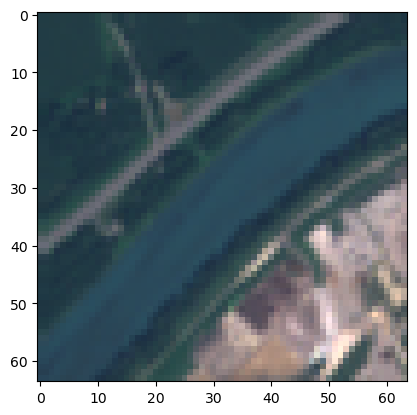

In [14]:
plt.imshow(val_data[739].permute(1, 2, 0))
text_labels[739]

## UMAP with PCA reduction

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=100).fit(train_data.flatten(1, -1).numpy())

In [17]:
train_data_reduced = pca.transform(train_data.flatten(1, -1).numpy())
val_data_reduced = pca.transform(val_data.flatten(1, -1).numpy())

In [18]:
umap_pca_2d = UMAP(n_neighbors=15)
_ = umap_pca_2d.fit(train_data_reduced)

In [19]:
projections = umap_2d.transform(val_data_reduced)

In [20]:
fig = px.scatter(
    projections, x=0, y=1,
    color=text_labels, labels={'color': 'Class'}, hover_name=np.arange(projections.shape[0])
)
fig.show()

## Using NCA (supervised!)

In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline

In [157]:
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
)
knn = KNeighborsClassifier(n_neighbors=3)
nca.fit(val_data.flatten(1, -1).numpy(), val_labels)  # SUPERVISED!
X_embedded = nca.transform(val_data.flatten(1, -1).numpy())
# knn.fit(nca.transform(val_data.flatten(1, -1).numpy()), val_labels)

In [158]:
fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1],
                 color=text_labels, labels={'color': 'Class'})
fig.update_xaxes(scaleanchor='y', scaleratio=2.5)

## Using Histograms?

Like in https://ieeexplore.ieee.org/abstract/document/10107974

In [120]:
train_min, train_max = train_data.min(), train_data.max()
train_min, train_max

(tensor(0.0004), tensor(1.))

In [131]:
train_hist = torch.zeros(train_data.shape[0], 32)
for i, im in enumerate(train_data):
    train_hist[i] += im.histc(bins=32, min=train_min, max=train_max)
# train_hist = train_hist.softmax(dim=1)

val_hist = torch.zeros(val_data.shape[0], 32)
for i, im in enumerate(val_data):
    val_hist[i] += im.histc(bins=32, min=train_min, max=train_max)
# val_hist = val_hist.softmax(dim=1)

In [132]:
umap_hist_2d = UMAP(n_neighbors=15, n_components=2)
umap_hist_2d.fit(train_hist)
projections = umap_2d.transform(val_hist)

In [133]:
fig = px.scatter(
    projections, x=0, y=1,
    color=text_labels, labels={'color': 'Class'}, hover_name=np.arange(projections.shape[0])
)
fig.show()

## Multispectral

In [86]:
ndvi_bands = ('B04', 'B08')
ndwi_bands = ('B08', 'B03')
eurosat_train_ds_ms = dataset_processing.eurosat.get_dataset("train", bands=ndwi_bands, download=False)
eurosat_val_ds_ms = dataset_processing.eurosat.get_dataset("val", bands=ndwi_bands, download=False)

In [87]:
train_ms_data, val_ms_data, val_ms_labels, val_ms_text_labels = get_n_samples(eurosat_train_ds_ms, eurosat_val_ds_ms)

In [88]:
train_combo_data = train_ms_data.diff(dim=1).squeeze(1) / train_ms_data.sum(dim=1)
val_combo_data = val_ms_data.diff(dim=1).squeeze(1) / val_ms_data.sum(dim=1)

River


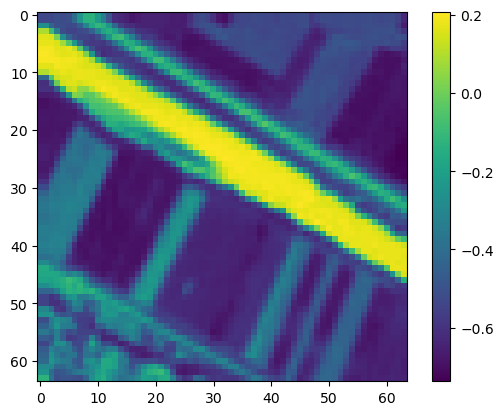

In [90]:
s = 0
plt.imshow(val_combo_data[s], cmap='viridis')
plt.colorbar()
print(val_ms_text_labels[s])

In [91]:
umap_ms = UMAP(n_neighbors=20, n_components=2)
umap_ms.fit(train_combo_data.flatten(1, -1).numpy())

UMAP(n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [92]:
projections = umap_ms.transform(val_combo_data.flatten(1, -1).numpy())
fig = px.scatter(
    projections, x=0, y=1,
    color=val_ms_text_labels, labels={'color': 'Class'}
)
fig.show()

In [93]:
umap_ms = UMAP(n_neighbors=20, n_components=3)
umap_ms.fit(train_combo_data.flatten(1, -1).numpy())

UMAP(n_components=3, n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [94]:
projections = umap_ms.transform(val_combo_data.flatten(1, -1).numpy())
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=val_ms_text_labels, labels={'color': 'Class'},
    size_max=1
)
fig.show()

In [85]:
fig = go.Figure(data=[go.Scatter3d(
    x=projections[:, 0],
    y=projections[:, 1],
    z=projections[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=val_labels,  # set color to an array/list of desired values
        colorscale='Rainbow',  # choose a colorscale
        opacity=0.8,
    ),
)])

fig.show()

# Using a pre-trained network as a feature extractor

In [5]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

In [6]:
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
get_graph_node_names(resnet50_model)

(['x',
  'conv1',
  'bn1',
  'relu',
  'maxpool',
  'layer1.0.conv1',
  'layer1.0.bn1',
  'layer1.0.relu',
  'layer1.0.conv2',
  'layer1.0.bn2',
  'layer1.0.relu_1',
  'layer1.0.conv3',
  'layer1.0.bn3',
  'layer1.0.downsample.0',
  'layer1.0.downsample.1',
  'layer1.0.add',
  'layer1.0.relu_2',
  'layer1.1.conv1',
  'layer1.1.bn1',
  'layer1.1.relu',
  'layer1.1.conv2',
  'layer1.1.bn2',
  'layer1.1.relu_1',
  'layer1.1.conv3',
  'layer1.1.bn3',
  'layer1.1.add',
  'layer1.1.relu_2',
  'layer1.2.conv1',
  'layer1.2.bn1',
  'layer1.2.relu',
  'layer1.2.conv2',
  'layer1.2.bn2',
  'layer1.2.relu_1',
  'layer1.2.conv3',
  'layer1.2.bn3',
  'layer1.2.add',
  'layer1.2.relu_2',
  'layer2.0.conv1',
  'layer2.0.bn1',
  'layer2.0.relu',
  'layer2.0.conv2',
  'layer2.0.bn2',
  'layer2.0.relu_1',
  'layer2.0.conv3',
  'layer2.0.bn3',
  'layer2.0.downsample.0',
  'layer2.0.downsample.1',
  'layer2.0.add',
  'layer2.0.relu_2',
  'layer2.1.conv1',
  'layer2.1.bn1',
  'layer2.1.relu',
  'layer2.1.c

In [7]:
class ResNet50FE(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet50.eval()
        self.body = create_feature_extractor(self.resnet50,
                                             return_nodes={'flatten': 'feature_v'})

    def forward(self, x):
        return self.body(x)['feature_v']


resnet50_fe = ResNet50FE().to(device)
resnet50_fe.eval()
resnet50_fe(torch.randn(5, 3, 64, 64).to(device)).size()

torch.Size([5, 2048])

In [8]:
val_dataloader_iter = iter(torch.utils.data.DataLoader(eurosat_val_ds, batch_size=128, num_workers=4, shuffle=True))

In [9]:
images = torch.zeros(0).to(device)
labels = torch.zeros(0).to(device)
feature_vecs = torch.zeros(0).to(device)
for batch in tqdm(range(6)):
    item = next(val_dataloader_iter)

    batch_ims = item["image"].to(device)
    # images = torch.cat((images, batch_ims.unsqueeze(0)), 0) if images.size(0) else batch_ims.unsqueeze(0)
    images = torch.cat((images, batch_ims), 0) if images.size(0) else batch_ims
    batch_lbls = item["label"].to(device)
    # labels = torch.cat((labels, batch_lbls.unsqueeze(0)), 0) if labels.size(0) else batch_lbls.unsqueeze(0)
    labels = torch.cat((labels, batch_lbls), 0) if labels.size(0) else batch_lbls

    fv = resnet50_fe(batch_ims)
    # feature_vecs = torch.cat((feature_vecs, fv), 0) if feature_vecs.size(0) else fv
    feature_vecs = torch.cat((feature_vecs, fv), 0) if feature_vecs.size(0) else fv

images = images.unsqueeze(0)
labels = labels.unsqueeze(0)
feature_vecs = feature_vecs.unsqueeze(0)
images.size(), feature_vecs.size()

  0%|          | 0/6 [00:00<?, ?it/s]

(torch.Size([1, 768, 3, 64, 64]), torch.Size([1, 768, 2048]))

In [10]:
from torch_kmeans import KMeans

In [11]:
kmeans = KMeans(n_clusters=10).to(device)
result = kmeans(feature_vecs)

Full batch converged at iteration 46/100 with center shifts = tensor([0.], device='cuda:0').


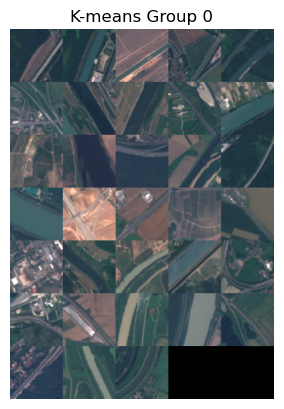

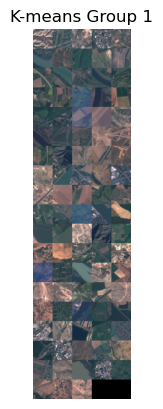

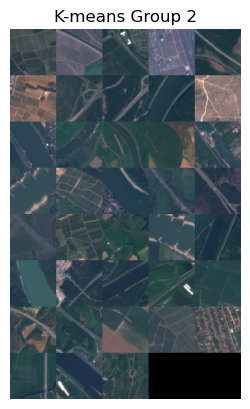

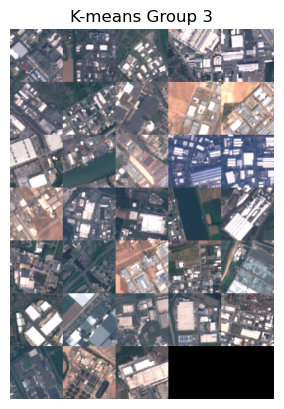

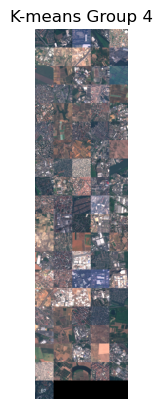

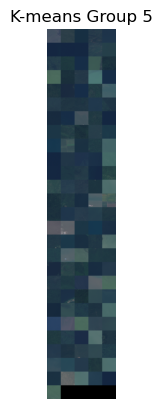

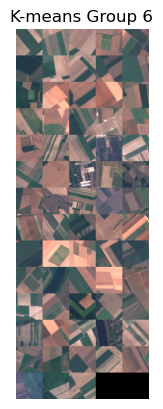

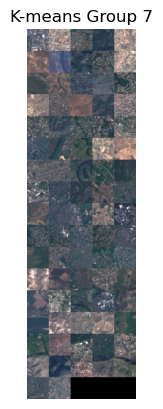

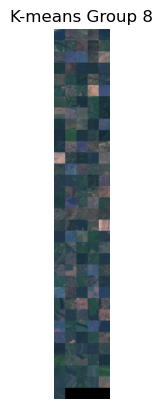

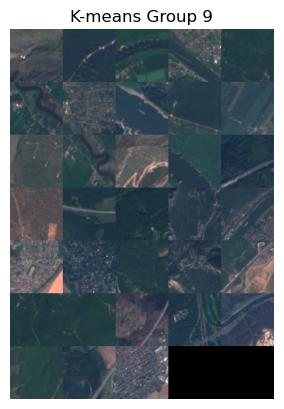

In [12]:
for i in range(10):
    group_images = images[0][result.labels[0] == i]
    plt.imshow(torchvision.utils.make_grid(group_images, nrow=5, padding=0).cpu().permute(1, 2, 0))
    plt.axis(False)
    plt.title(f'K-means Group {i}')
    plt.show()

In [13]:
sort_of_predicted_labels = labels.clone().detach().cpu()
for i in range(10):
    group_mask = result.labels[0] == i
    most_common_label = np.bincount(labels[0][group_mask].cpu()).argmax()
    # print(eurosat_val_ds.classes[most_common_label])
    sort_of_predicted_labels[0][group_mask] = most_common_label
# sort_of_predicted_labels[0]

In [14]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score

In [15]:
for metric in (normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score):
    print(f'{metric.__name__}: {metric(labels[0].cpu(), sort_of_predicted_labels[0].cpu()):.4f}')

normalized_mutual_info_score: 0.4029
adjusted_mutual_info_score: 0.3925
adjusted_rand_score: 0.2726
